<a href="https://colab.research.google.com/github/NUG30/homework-3-duongnghiephuy123/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: k-means clustering

The goal of this homework is to implement the k-means algorithm, i.e. to find k clusters in a given dataset. The following code creates testdata which you can use to test your implementation. It uses the functon `make_blobs` of the sklearn package (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html for mor information on this function). 

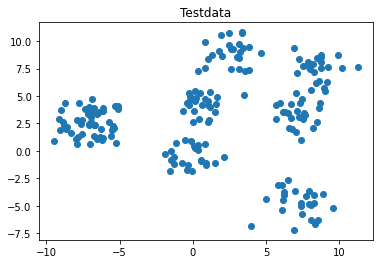

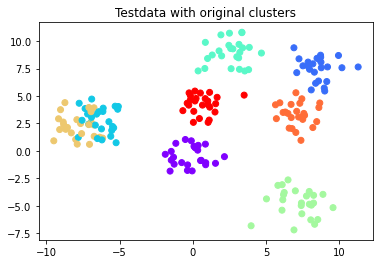

In [1]:
## Creating the testdata
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
from sklearn.datasets import make_blobs # We use this to create sample data

d=2 # dimensions. In our example 2
number_of_clusters = 8 

# The following code creates random datapoints with number_of_clusters clusters in d dimensions (cluster_std gives the standard deviation. bigger -> wider spread)
data = make_blobs(n_samples=200, n_features=d,centers=number_of_clusters, cluster_std=1)

# The datapoints
points = data[0]

# The cluster assignment used in the creation of the data. This is what we want to obtain by ourself by just considering the points
# contains numbers 0,...,number_of_clusters-1
original_clusters = data[1]

# plots the data points with the original cluster assignment
plt.title("Testdata")
plt.scatter(points[:,0],points[:,1])
plt.show()

plt.title("Testdata with original clusters")
plt.scatter(points[:,0],points[:,1],c=original_clusters,cmap='rainbow')
plt.show()

## Recall from the lecture
Given a $k\geq 1$ (number of clusters) a set of points $P \subset \mathbb{R}^d$ we want to find a function $c: P \rightarrow \{1,\dots,k\}$ which gives the best way of partitioning the set $P$ into $k$ clusters.

For $i=1,\dots,k$ the $i$-th **cluster** is given by 
\begin{align*}
C_i = \left\{ p \in P \mid c(p) = i \right\} \,.
\end{align*}

For a given $c$ the **within-cluster sum of squares (WCSS)** is defined by
\begin{align*}
	S_c = \sum_{i=1}^k \sum_{p \in C_i} ||p - \mu_i||^2 \,.
\end{align*}
Here $\mu_i \in \mathbb{R}^d$ denotes the **mean** of the cluster $C_i$ given by
\begin{align*}
	\mu_i = \frac{1}{|C_i|}\sum_{p \in C_i} p\,.
\end{align*}
The goal is to find a $c$ such that $S_c$ is minimal.


---


## k-means algorithm

1) Initialize the  means $\mu_1, \dots, \mu_k \in \mathbb{R}^d$ with some starting value.
 - **Forgy method:** Choose randomly $k$ different numbers $\{s_1,\dots,s_k\} \subset \{1,\dots,n\}$ and set $$\mu_i= p_{s_i}$$ for $i=1,\dots,k$
 -**Random partition:** Choose $c: P \rightarrow \{1, \dots, k\}$ randomly and set  for $i=1,\dots,k$
\begin{align*}
						\mu_i = \frac{1}{|C_i|}\sum_{p \in C_i} p\,.
\end{align*}

2) Define the clusters $C_i$ for $i=1,\dots,k$ by 
\begin{align*}
	C_i = \big\{ p \in P \mid || p - \mu_i || \leq  || p - \mu_j ||  \text{ for } j = 1,\dots,k \big\}\,.
\end{align*}

3) Recalculate the means $\mu_i$ for $i=1,\dots,k$ by 
\begin{align*}
	\mu_i = \frac{1}{|C_i|}\sum_{p \in C_i} p\,.
\end{align*}

4) Repeat with step 2.



# **Exercise 1**

Implement the k-means algorithm. You can either implement it in your complete own (and maybe much better) way or you can follow the code below. In the code below we represent the function $c: P \rightarrow \{1,\dots,k\}$ as an array of size $n = |P|$ with entries given in $\{0,\dots,k-1\}$.
*italicized text*

In [33]:
#My implementation

#Distance between two data points
def distance(point1,point2):
    point1=np.array(point1)
    point2=np.array(point2)
    return np.linalg.norm(point1-point2)

#Cluster class to easily manipulate data
class Cluster():
    def __init__(self,data):
        self.data=np.array(data)
        self.centroid=self.computeCentroid()

    #Update cluster to a different set of points
    def update(self,newdata):
        oldcentroid=self.centroid
        self.data=np.array(newdata)
        self.centroid=self.computeCentroid()
        return distance(oldcentroid,self.centroid)

    #Compute cluster mean
    def computeCentroid(self):
        return np.mean(self.data,axis=0)
    #Get cluster mean
    def getCentroid(self):
        return self.centroid

    #Compute the spread of points in cluster
    def variability(self):
        total=0
      
        for point in self.data:
            total+=distance(point,self.centroid)
        return total
    
    #Get points in cluster
    def members(self):
        for point in self.data:
            yield point

#Compute total spread of a list of clusters
def totalvariability(clusters):
    res=0
    for cluster in clusters:
        res+=cluster.variability()
    return res

In [69]:
from numpy.random import default_rng

#Forgy partition 
def forgy(data,k):
  rng=default_rng()
  k_indexes=rng.choice(range(data.shape[0]),replace=False,size=k)
  initialCentroids=[]
  for index in k_indexes:
        initialCentroids.append([data[index]])
  return initialCentroids

#Random partition
def random_partition(data,k):
  rng=default_rng()
  ids=rng.choice(range(k),replace=True,size=data.shape[0])
  initial=[[] for i in range(k)]
  for i,id in enumerate(ids):
    initial[id].append(data[i])
  return initial

#kmeans algorithm
def kmeans(data,k,partition):
    #Partition and initialization of clusters
    initialCentroids=partition(data,k)
    clusters=[]
    for e in initialCentroids:
        clusters.append(Cluster(e))
    
    converge=False
    while not converge:

        #Assign points to clusters
        newClusters=[[] for i in range(k)]
        for point in data:
            mindist=float("inf")
            index=None
            for i,cluster in enumerate(clusters):
                currentdist=distance(point,cluster.getCentroid())
                if currentdist<mindist:
                    mindist=currentdist
                    index=i
            newClusters[index].append(point)

        #Check convergence
        converge=True
        for i,newcluster in enumerate(newClusters):
          if len(newcluster)==0:
            raise ValueError("Empty cluster")
          if clusters[i].update(newcluster)>0:
            converge=False

    return clusters

#Repeat kmeans algorithm to have best result
def repeat(nums,data,k,partition=forgy):
    res=None
    minres=float("inf")
    trial=0
    while trial<nums:

        #If there is empty cluster, repeak kmeans
        try:
          clusters=kmeans(data,k,partition)
        except ValueError:
          continue

        #Pick best result
        current=totalvariability(clusters)
        if current<minres:
            minres=current
            res=clusters
        trial+=1

    return res


                

Test your implementation with the following code (You can also implement your own tests).


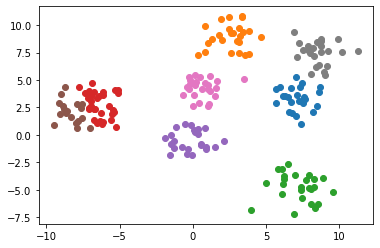

In [70]:
#Forgy k-means
clusters=repeat(20,points,8)
plt.figure()
for cluster in clusters:
  members=np.array([member for member in cluster.members()])
  plt.scatter(members[:,0],members[:,1])
plt.show()


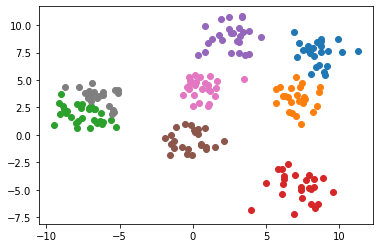

In [71]:
#Random partition k-means
clusters=repeat(20,points,8,partition=random_partition)
plt.figure()
for cluster in clusters:
  members=np.array([member for member in cluster.members()])
  plt.scatter(members[:,0],members[:,1])
plt.show()

# **Exercise 2** (Bonus)

For a given dataset consider different $k$. Plot the WCSS for different $k$ after using the $k$-means algorithm. How can you decide with this graph which $k$ might be the best?

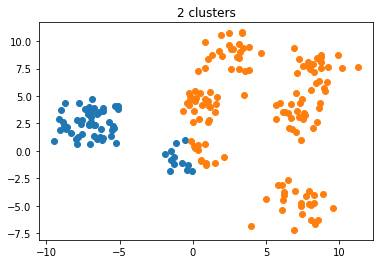

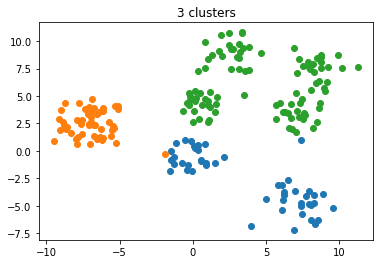

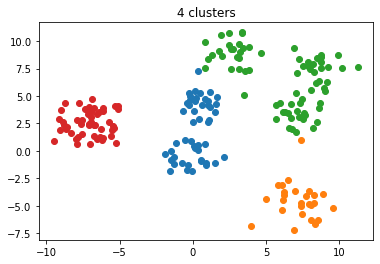

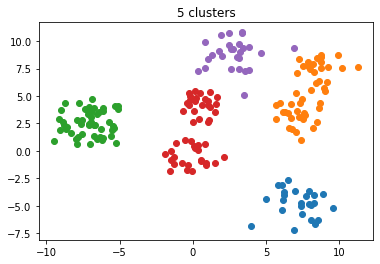

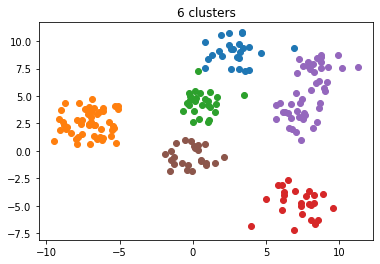

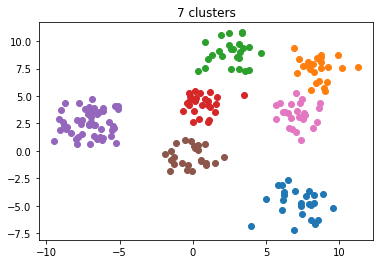

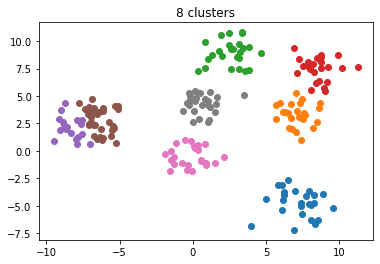

In [73]:
#Forgy k-means
for k in range(2,9):

  clusters=repeat(20,points,k)
  plt.figure(k-1)
  for cluster in clusters:
    members=np.array([member for member in cluster.members()])
    plt.scatter(members[:,0],members[:,1])
  plt.title("{} clusters".format(k))
plt.show()

Decide either by the total spread or by visual considering other factors and requirements. 